<a href="https://colab.research.google.com/github/AmalAbdelsalam/NMA-Project-RL/blob/master/Steinmetz_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Neural Mechanisms of Reward Association in Reinforcement Learning
# Team: Hummuscides, pod-144

Authors:__ Amal, Rawan and Ali

Mentor:__ Cory

TA:__ Mohamed

---

# Scientific Background
  
Reinforcement learning is integral to our understanding of reward-driven decision making however the neural correlates of this process is less clear. In particular, how and where decision outcome relationships are retained regardless of reward outcome. This map of the different outcome associations and their relative weights should be utilised to direct future behaviour. The amygdala plays an important role in creating associations and assigning valence. Moreover, neural recordings that utilise learned reward suggest that these signals can be found in both the PFC and amygdala. Using the current task structure, we aim to identify the neural substrates that retain this information by comparing across trials and adjusting the expectation of reward variable with a reinforcement learning model.

<!-- We will consider here the example of spatial navigation, where actions (movements) in one state (location) affect the states experienced next, and an agent might need to execute a whole sequence of actions before a reward is obtained.

By the end of this tutorial, you will learn
* what grid worlds are and how they help in evaluating simple reinforcement learning agents
* the basics of the Q-learning algorithm for estimating action values
* how the concept of exploration and exploitation, reviewed in the bandit case, also applies to the sequential decision setting -->

In [108]:
# Imports
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from scipy.signal import convolve as conv

# Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [ ]:
#@title Data Processing

# brain regions of interest
filtered_areas = ['MEA','PL','BLA','BMA','ILA']

# filter data of spikes & regions  
filtered_regions = np.array([])
spiking_rates = np.array([])

c = 0
for i in range(alldat.shape[0]):
    dat = alldat[i]
    indices = np.nonzero(np.isin(dat['brain_area'], filtered_areas))
    c = c + len(indices[0])
    if len(indices[0]) > 0 :
        filtered_regions = np.append(filtered_regions, dat['brain_area'][indices])
        # spiking_rates = 
        # TODO compute spiking rates

print(c)

1736


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'topright'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


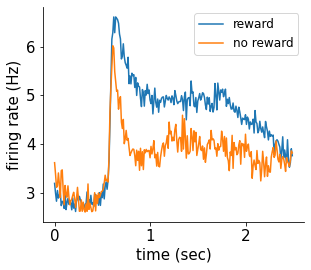

In [ ]:
#@title Exploratory Visualization

# sample plot for a simulation-area pair
n = 7
filtered_areas = ['PL']

dat = alldat[n]
indices = np.nonzero(np.isin(dat['brain_area'], filtered_areas))
filtered_regions = np.append(filtered_regions, dat['brain_area'][indices])

c = c + len(indices[0])
if len(indices[0]) > 0 :
    
    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    feedback = dat['feedback_time']
    avg = np.mean(feedback)

    ax = plt.subplot(1,5,1)
    response = dat['feedback_type'] # dat['response'] # right - nogo - left (-1, 0, 1)
    vis_right = dat['contrast_right'] # 0 - low - high
    vis_left = dat['contrast_left'] # 0 - low - high
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][indices][:, response>=0].mean(axis=(0,1))) # left responses
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][indices][:, response<0].mean(axis=(0,1))) # right responses

    plt.legend(['reward', 'no reward'], fontsize=12, loc='topright')
    ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

## RL Model Training

# Compare to actual behavioral data

In [ ]:
all_response = []
all_contrast_right =  []
all_contrast_left = []
all_reward=[]

for i in range(len(alldat)):
  all_response.append(alldat[i]['response'])
  all_contrast_right.append(alldat[i]['contrast_right'])
  all_contrast_left.append(alldat[i]['contrast_left'])
  all_reward.append(alldat[i]['feedback_type'])


contrast_left=[]
contrast_right=[]
responses_all=[]

for k in range(39):
  responses_all.append(all_response[k])
responses_all_one=np.concatenate(responses_all,axis=None)
for i in range(39):
  contrast_left.append(all_contrast_left[i])
contrast_left_one=np.concatenate(contrast_left,axis=None)
print(len(contrast_left_one))
for i in range(39):
  contrast_right.append(all_contrast_right[i])
contrast_right_one=np.concatenate(contrast_right,axis=None)
print(len(contrast_right_one))
combination=[]
for j in range(len(contrast_left_one)):
  combination.append(np.concatenate((contrast_left_one[j],contrast_right_one[j]),axis=None))
print(len(combination))
print(combination)
actual_state=[]
for i in range(len(combination)):
  if combination[i][0]==0 and combination[i][1]==0:
    actual_state.append(0)
  if combination[i][0]==0 and combination[i][1]==0.25:
    actual_state.append(1)
  if combination[i][0]==0 and combination[i][1]==0.5:
    actual_state.append(2)
  if combination[i][0]==0 and combination[i][1]==1:
    actual_state.append(3)
  if combination[i][0]==0.25 and combination[i][1]==0:
    actual_state.append(4)
  if combination[i][0]==0.25 and combination[i][1]==0.25:
    actual_state.append(5)
  if combination[i][0]==0.25 and combination[i][1]==0.5:
    actual_state.append(6)
  if combination[i][0]==0.25 and combination[i][1]==1:
    actual_state.append(7)
  if combination[i][0]==0.5 and combination[i][1]==0:
    actual_state.append(8)
  if combination[i][0]==0.5 and combination[i][1]==0.25:
    actual_state.append(9)
  if combination[i][0]==0.5 and combination[i][1]==0.5:
    actual_state.append(10)
  if combination[i][0]==0.5 and combination[i][1]==1:
    actual_state.append(11)
  if combination[i][0]==1 and combination[i][1]==0:
    actual_state.append(12)
  if combination[i][0]==1 and combination[i][1]==0.25:
    actual_state.append(13)
  if combination[i][0]==1 and combination[i][1]==0.5:
    actual_state.append(14)
  if combination[i][0]==1 and combination[i][1]==1:
    actual_state.append(15)

10050
10050
10050
[array([1., 0.]), array([0. , 0.5]), array([1. , 0.5]), array([0., 0.]), array([0.5, 1. ]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([1. , 0.5]), array([0.5, 0. ]), array([0., 0.]), array([0.5 , 0.25]), array([1., 0.]), array([0.5, 0. ]), array([0., 1.]), array([0., 0.]), array([1., 1.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0.5, 0. ]), array([0., 0.]), array([0., 0.]), array([0. , 0.5]), array([0.5 , 0.25]), array([0.25, 1.  ]), array([0.25, 1.  ]), array([0., 0.]), array([1. , 0.5]), array([0.5, 0. ]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0.  , 0.25]), array([0.5, 1. ]), array([0.25, 0.  ]), array([1.  , 0.25]), array([0. , 0.5]), array([0., 1.]), array([0., 0.]), array([0., 0.]), array([0. , 0.5]), array([0., 1.]), array([0.5, 0. ]), array([0.25, 0.25]), array([0.5, 0. ]), array([0., 1.]), array([0., 0.]), array([0., 0.]), array([1.  , 0.25]

In [ ]:
# actual_state = np.array(actual_state)
behavioral_data = np.array([actual_state, responses_all_one + 1])

# State Representation & Model Building


> Indented block


![state representation](https://drive.google.com/file/d/1k2wj5c7xYFfXOOhPjSAYd-WhscM-2sKA/view?usp=sharing)

In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [173]:
#@title Visualization Code

def plot_state_action_values(env, rewards, preds, ax=None):
  """
  Generate plot showing value of reward at episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

#   ax.plot(range(rewards.shape[0]), rewards, marker='o', linestyle='--', color = 'blue')
  ax.plot(range(preds.shape[0]), preds, marker='o', linestyle='--', color = 'red')
  ax.set(xlabel='Sessions', ylabel='Reward %')
  ax.set(ylim=[0.0, 1.0])
  

def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5

  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]

  U = np.zeros(X.shape)
  V = np.zeros(X.shape)

  U[which_max == 2] = 1
  U[which_max == 1] = -1
  
  ax.quiver(X, Y, U, V)
  ax.set(
      title='Action Probability',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],      
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))  
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y)])  
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))      
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(0, env.dim_y)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
#   smoothed_
  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range], marker='o')
  ax.set(xlabel='Episodes', ylabel='Total reward')
  

def plot_performance(env, value, reward_sums, pred_acc):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, reward_sums, pred_acc, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

In [116]:
#@title Reinforcement Learning Model Implementation

def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.
    
  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly 
  
  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q)) 

  return action

def q_learning(state, action, reward, next_state, value, params):
  # Q-value of current state-action pair
  q = value[state, action]

  # find the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * max_next_q - q

  # write the expression that updates the Q-value for the state-action pair  
  value[state, action] = q + params['alpha'] * td_error
  
  return value

class ChoiceEncoder:

  def __init__(self, evaluation_set):
    self.name = "ChoiceEncoder"
    self.n_states = 16
    self.n_actions = 3
    self.dim_x = 4
    self.dim_y = 4
    # self.init_state = np.random.choice(np.arange(0,16))
    self.state_lst = [0,2,3,8,10,11,12,14,15]
    self.eval_set = evaluation_set

 ## we have 16 possible states & None next_state

  def get_outcome(self, state, action):
      if action == 2:
          if state in [1,2,3,5,6,7,10,11,15]:
              reward = 1
          else:
              reward = 0

      elif action == 1:
          if state in [4,5,8,9,10,12,13,14,15]:
              reward = 1
          else:
              reward = 0

      elif action == 0:
          if state == 0:
              reward = 1
          else:
              reward = 0

      return reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, reward)]
    return outcomes
  

def learn_environment(env, learning_rule, params, max_steps, n_episodes): 
  # Start with a uniform value function
  value = np.zeros((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)
  prediction_acc = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = np.random.choice(env.state_lst)  # initialize state    
    reward_sum = 0 
    correct_predictions = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])
      
      # observe outcome of action on environment
      reward = env.get_outcome(state, action)  ### TODO ensure the shuffling of action direction
      next_state = None

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)
      
      # sum rewards obtained
      reward_sum += reward 

      #   print('episode: %d .. state: %d .. action: %d .. reward: %d .. value: %s' % (episode,state,action,reward,str(value)))

      if np.round(reward_sum/max_steps, decimals=2) > 0.7: 
          env.state_lst = np.arange(0,16)
          
      state = np.random.choice(env.state_lst)

    # TODO evaluate model for actual-states
    for i in range(env.eval_set.shape[1]):
      action = epsilon_greedy(value[int(env.eval_set[0][i])], params['epsilon'])
      reward = env.get_outcome(state, action)
      correct_predictions += reward #(1 if action == env.eval_set[0][i] else 0)
    
    reward_sums[episode] = np.round(reward_sum/max_steps, decimals=2)
    print('episode = %d .. correct_acc = %d' % (episode, correct_predictions))
    prediction_acc[episode] = np.round(correct_predictions/env.eval_set.shape[1], decimals=2)
  
  return value, reward_sums, prediction_acc

In [170]:
#@title Model Training Script

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.3,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate    
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 200
max_steps = 100

# environment initialization
env = ChoiceEncoder(behavioral_data)

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning, predictions = results


episode = 0 .. correct_acc = 1478
episode = 1 .. correct_acc = 2307
episode = 2 .. correct_acc = 2389
episode = 3 .. correct_acc = 3051
episode = 4 .. correct_acc = 3051
episode = 5 .. correct_acc = 3328
episode = 6 .. correct_acc = 6578
episode = 7 .. correct_acc = 3326
episode = 8 .. correct_acc = 7164
episode = 9 .. correct_acc = 7232
episode = 10 .. correct_acc = 3297
episode = 11 .. correct_acc = 7147
episode = 12 .. correct_acc = 3225
episode = 13 .. correct_acc = 3305
episode = 14 .. correct_acc = 7164
episode = 15 .. correct_acc = 3359
episode = 16 .. correct_acc = 7218
episode = 17 .. correct_acc = 3952
episode = 18 .. correct_acc = 3835
episode = 19 .. correct_acc = 3909
episode = 20 .. correct_acc = 3841
episode = 21 .. correct_acc = 7183
episode = 22 .. correct_acc = 2890
episode = 23 .. correct_acc = 7241
episode = 24 .. correct_acc = 3299
episode = 25 .. correct_acc = 3857
episode = 26 .. correct_acc = 3853
episode = 27 .. correct_acc = 2838
episode = 28 .. correct_acc = 

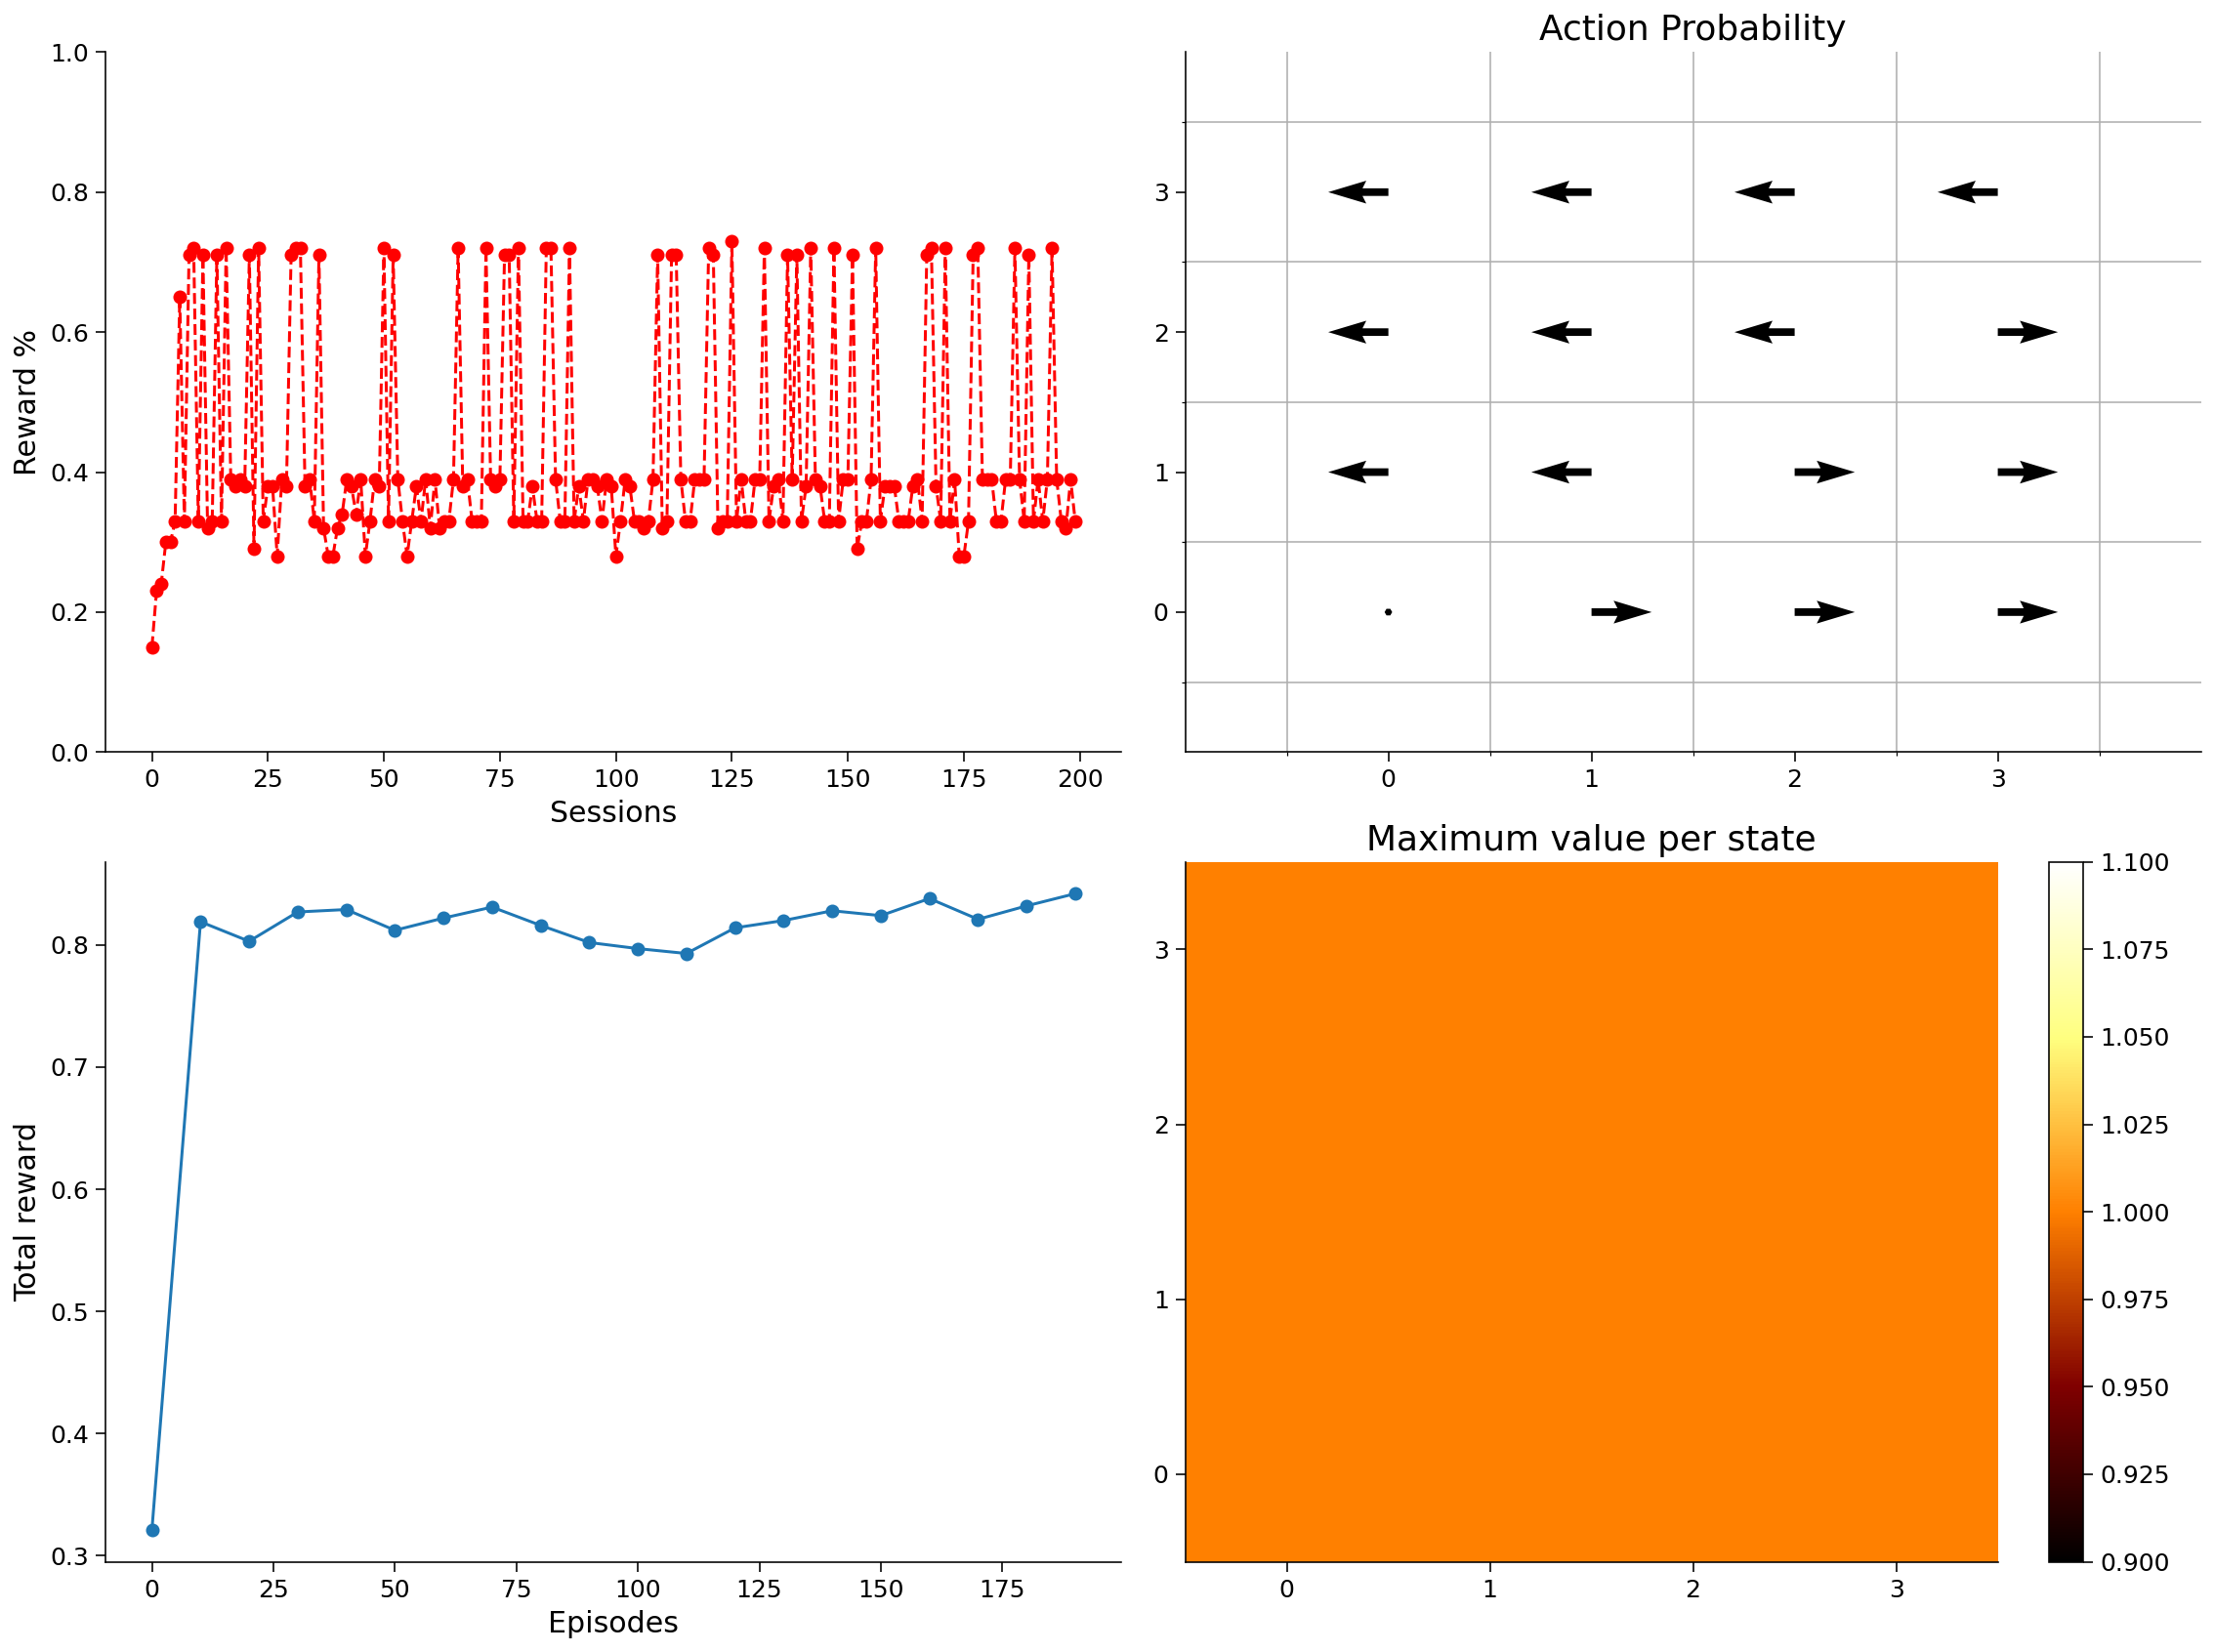

In [174]:
# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning, predictions)

In [175]:
predictions

array([0.15, 0.23, 0.24, 0.3 , 0.3 , 0.33, 0.65, 0.33, 0.71, 0.72, 0.33,
       0.71, 0.32, 0.33, 0.71, 0.33, 0.72, 0.39, 0.38, 0.39, 0.38, 0.71,
       0.29, 0.72, 0.33, 0.38, 0.38, 0.28, 0.39, 0.38, 0.71, 0.72, 0.72,
       0.38, 0.39, 0.33, 0.71, 0.32, 0.28, 0.28, 0.32, 0.34, 0.39, 0.38,
       0.34, 0.39, 0.28, 0.33, 0.39, 0.38, 0.72, 0.33, 0.71, 0.39, 0.33,
       0.28, 0.33, 0.38, 0.33, 0.39, 0.32, 0.39, 0.32, 0.33, 0.33, 0.39,
       0.72, 0.38, 0.39, 0.33, 0.33, 0.33, 0.72, 0.39, 0.38, 0.39, 0.71,
       0.71, 0.33, 0.72, 0.33, 0.33, 0.38, 0.33, 0.33, 0.72, 0.72, 0.39,
       0.33, 0.33, 0.72, 0.33, 0.38, 0.33, 0.39, 0.39, 0.38, 0.33, 0.39,
       0.38, 0.28, 0.33, 0.39, 0.38, 0.33, 0.33, 0.32, 0.33, 0.39, 0.71,
       0.32, 0.33, 0.71, 0.71, 0.39, 0.33, 0.33, 0.39, 0.39, 0.39, 0.72,
       0.71, 0.32, 0.33, 0.33, 0.73, 0.33, 0.39, 0.33, 0.33, 0.39, 0.39,
       0.72, 0.33, 0.38, 0.39, 0.33, 0.71, 0.39, 0.71, 0.33, 0.38, 0.72,
       0.39, 0.38, 0.33, 0.33, 0.72, 0.33, 0.39, 0.

## Extract behavioral Data

In [ ]:
all_response = []
all_contrast_right =  []
all_contrast_left = []

for i in range(len(alldat)):
  all_response.append(alldat[i]['response'])
  all_contrast_right.append(alldat[i]['contrast_right'])
  all_contrast_left.append(alldat[i]['contrast_left'])


In [ ]:
import pickle
contrast_left=[]
contrast_right=[]
responses_all=[]
for k in range(39):
  responses_all.append(all_response[k])
responses_all_one=np.concatenate(responses_all,axis=None)
for i in range(39):
  contrast_left.append(all_contrast_left[i])
contrast_left_one=np.concatenate(contrast_left,axis=None)
print(len(contrast_left_one))
for i in range(39):
  contrast_right.append(all_contrast_right[i])
contrast_right_one=np.concatenate(contrast_right,axis=None)
print(len(contrast_right_one))
combination=[]
for j in range(len(contrast_left_one)):
  combination.append(np.concatenate((contrast_left_one[j],contrast_right_one[j]),axis=None))
print(len(combination))
print(combination)
state=[]
for i in range(len(combination)):
  if combination[i][0]==0 and combination[i][1]==0:
    state.append(0)
  if combination[i][0]==0 and combination[i][1]==0.25:
    state.append(1)
  if combination[i][0]==0 and combination[i][1]==0.5:
    state.append(2)
  if combination[i][0]==0 and combination[i][1]==1:
    state.append(3)
  if combination[i][0]==0.25 and combination[i][1]==0:
    state.append(4)
  if combination[i][0]==0.25 and combination[i][1]==0.25:
    state.append(5)
  if combination[i][0]==0.25 and combination[i][1]==0.5:
    state.append(6)
  if combination[i][0]==0.25 and combination[i][1]==1:
    state.append(7)
  if combination[i][0]==0.5 and combination[i][1]==0:
    state.append(8)
  if combination[i][0]==0.5 and combination[i][1]==0.25:
    state.append(9)
  if combination[i][0]==0.5 and combination[i][1]==0.5:
    state.append(10)
  if combination[i][0]==0.5 and combination[i][1]==1:
    state.append(11)
  if combination[i][0]==1 and combination[i][1]==0:
    state.append(12)
  if combination[i][0]==1 and combination[i][1]==0.25:
    state.append(13)
  if combination[i][0]==1 and combination[i][1]==0.5:
    state.append(14)
  if combination[i][0]==1 and combination[i][1]==1:
    state.append(15)

print(len(state))
print(state)
print(len(responses_all_one))
file_name5 = 'responses.cvs'
with open(file_name5[:-4],'wb') as f:
  pickle.dump(responses_all_one,f)   

file_name6 = 'state.cvs'
with open(file_name6[:-4],'wb') as f:
  pickle.dump(state,f) 